<a href="https://colab.research.google.com/github/SirSirocco/DataScience_2025_1/blob/main/random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DEPENDÊNCIAS

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
from sklearn.base import clone, BaseEstimator
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

# FUNÇÕES

In [28]:
def df_show_head(df: pd.DataFrame, n: int = 5) -> None:
    display(df.head(n))
    print(f"Shape: {df.shape}")

def cross_val(model: BaseEstimator,
              X: pd.DataFrame,
              y: pd.Series,
              n_splits: int = 5,
              metric: str = "r2",
              shuffle: bool = True,
              random_state: int | None = None) -> tuple[list[BaseEstimator], list[float]]:
    """
    Realiza validação cruzada com K-Fold para treinar e avaliar um modelo,
    utilizando uma métrica especificada para avaliar o desempenho em cada fold.
    O modelo é clonado e treinado novamente a cada divisão dos dados.

    Args:
        model (sklearn.base.BaseEstimator): Modelo que implementa os métodos `fit` e `predict`.
        X (pandas.DataFrame): Conjunto de dados de entrada (features).
        y (pandas.Series): Vetor alvo (target) correspondente às amostras em `X`.
        n_splits (int, optional): Número de folds da validação cruzada. Default é 5.
        metric (str, optional): Métrica de avaliação a ser utilizada.
            Opções válidas: "r2", "mse", "mae". Caso a métrica seja inválida, será usada a default: "r2".
        shuffle (bool, optional): Se True, embaralha os dados antes de dividir em folds. Default é True.
        random_state (int or None, optional): Semente usada para o embaralhamento. Default é None (comportamento randômico).

    Returns:
        tuple:
            models (list): Lista de modelos treinados, um para cada fold.
            metrics (list): Lista de valores da métrica de avaliação para cada fold.

    Note:
        Se uma métrica inválida for fornecida, a função utilizará "r2" como padrão, sem gerar erro.
    """
    DICT_METRICS = {
        "r2":   r2_score,
        "mse":  mean_squared_error,
        "mae":  mean_absolute_error
    }
    models = list()
    metrics = list()
    metric_to_use = DICT_METRICS.get(metric, r2_score)

    # Define os índices que delimitam as partições
    kfolds = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

    # Percorre os folds
    for i, (train_index, test_index) in enumerate(kfolds.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        copy = clone(model)
        copy.fit(X_train, y_train)

        models.append(copy)
        metrics.append(metric_to_use(y_test, copy.predict(X_test))) # Calcula métrica

    return models, metrics

# _SETUP_ DO AMBIENTE

In [29]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# OBTENÇÃO DO _DATASET_

In [30]:
PATH = "/content/drive/MyDrive/07_per_shared/projCDat_25_1/datasets/cooked/_all/all_merged.csv"

df = pd.read_csv(PATH)
df_show_head(df)

,_ano,_estado,_mes,car_c02_emitido,cli_pressao_atm_med,cli_temp_ar_med,cli_temp_orvalho_med,cli_umid_rel_med,cli_umid_rel_min_max,cli_umid_rel_min_med,cli_umid_rel_min_min,cli_veloc_vento_max,cli_veloc_vento_med,que_area_queimada,que_focos_qtd
0,2008,AC,7,2.627698e+07,986.843612,28.142731,18.914978,59.555066,95.0,54.432558,29.0,5.1,2.152915,4957.0,165.0
1,2008,AC,9,2.627698e+07,991.705941,24.446194,19.467987,75.811881,97.0,72.496700,25.0,1.0,0.210504,46073.0,2947.0
2,2008,AC,10,2.627698e+07,990.328360,25.229298,21.617473,81.870968,96.0,78.720430,29.0,1.0,0.204959,30355.0,856.0
3,2008,AC,11,2.627698e+07,988.610987,25.195410,22.624478,86.905424,96.0,84.048679,42.0,1.0,0.186970,2082.0,63.0
4,2008,AC,12,2.627698e+07,988.692608,24.898790,22.727554,88.529570,96.0,86.116935,53.0,1.0,0.179442,127.0,4.0


Shape: (1025, 15)


# VISUALIZAÇÃO DAS INSTÂNCIAS

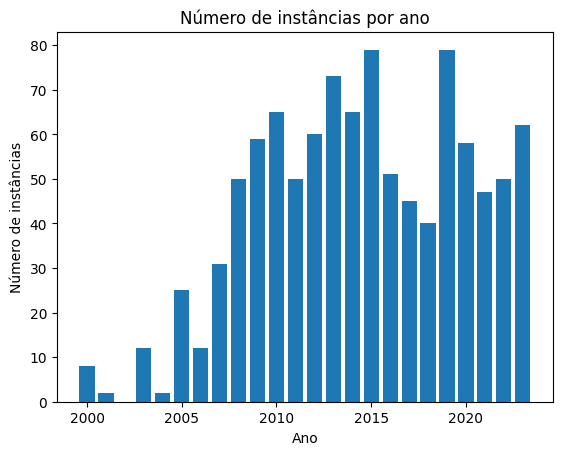

In [31]:
# CONSTANTES AUXILIARES
PAIR = "pair"
STATE = "_estado"
MONTH = "_mes"
YEAR = "_ano"

# Contagem de instâncias por ano
df_aux = df.copy()
df_aux[PAIR] = list(zip(df_aux[MONTH], df_aux[STATE])) # Gera coluna auxiliar (mes, estado)
count_per_year = df_aux.groupby(YEAR)[PAIR].count() # Conta ocorrências de pares (mes, estado)

# Eixos do gráfico
X = "Ano"
Y = "Número de instâncias"

# Visualização da distribuição de instâncias por ano
plt.bar(count_per_year.index, count_per_year.values)
plt.title(f"{Y} por {X.lower()}")
plt.xlabel(X)
plt.ylabel(Y)
plt.show()

# CODIFICAÇÃO

In [32]:
# Codificação OneHot simplificada
TO_ENCODE = ["_estado"]
df_encoded = pd.get_dummies(df, columns=TO_ENCODE, dtype="Int32")

df_show_head(df_encoded)

,_ano,_mes,car_c02_emitido,cli_pressao_atm_med,cli_temp_ar_med,cli_temp_orvalho_med,cli_umid_rel_med,cli_umid_rel_min_max,cli_umid_rel_min_med,cli_umid_rel_min_min,...,cli_veloc_vento_med,que_area_queimada,que_focos_qtd,_estado_AC,_estado_AM,_estado_AP,_estado_PA,_estado_RO,_estado_RR,_estado_TO
0,2008,7,2.627698e+07,986.843612,28.142731,18.914978,59.555066,95.0,54.432558,29.0,...,2.152915,4957.0,165.0,1,0,0,0,0,0,0
1,2008,9,2.627698e+07,991.705941,24.446194,19.467987,75.811881,97.0,72.496700,25.0,...,0.210504,46073.0,2947.0,1,0,0,0,0,0,0
2,2008,10,2.627698e+07,990.328360,25.229298,21.617473,81.870968,96.0,78.720430,29.0,...,0.204959,30355.0,856.0,1,0,0,0,0,0,0
3,2008,11,2.627698e+07,988.610987,25.195410,22.624478,86.905424,96.0,84.048679,42.0,...,0.186970,2082.0,63.0,1,0,0,0,0,0,0
4,2008,12,2.627698e+07,988.692608,24.898790,22.727554,88.529570,96.0,86.116935,53.0,...,0.179442,127.0,4.0,1,0,0,0,0,0,0


Shape: (1025, 21)


# NORMALIZAÇÃO E DIVISÃO EM TREINO E TESTE

In [33]:
# --- PARÂMETROS ---
# - Normalização -
NORMALIZE = True
RANGE = (0.0, 1.0)

# - Treino e teste -
TARGET = "que_area_queimada"
YEAR_DIV = 2017 # Último ano do conjunto de treino

# Divide DataFrame em treino e teste com intervalos de tempo disjuntos
df_train = df_encoded.loc[df_encoded[YEAR] <= YEAR_DIV]
df_test = df_encoded.loc[YEAR_DIV < df_encoded[YEAR]]
X = df_encoded.drop(columns=TARGET)
X_train = df_train.drop(columns=TARGET)
X_test = df_test.drop(columns=TARGET)

if NORMALIZE:
    scaler = MinMaxScaler(feature_range=RANGE)
    scaler.fit(X)
    X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Define alvo sem normalização para melhor interpretabilidade
y_train = df_train[TARGET]
y_test = df_test[TARGET]

# MODELO

In [34]:
# PARÂMETROS
RANDOM_STATE = 42
PARAMS = {
    "n_estimators": 100,
    "criterion": "squared_error",
    "max_depth": 10,
    "random_state": RANDOM_STATE
}
model = RandomForestRegressor(**PARAMS)

In [35]:
# PARÂMETROS
FOLD_NUM = 5 # Número de folds da Validação cruzada
DICT_METRIC_NAME = {
    "r2":  "Coeficiente de Determinação",
    "mse": "Erro Quadrático Médio",
    "mae": "Erro Absoluto Médio",
}

# VARIÁVEIS AUXILIARES
dict_models = dict() # Armazena array com os modelos de cada fold com base no nome da métrica
dict_scores = dict() # Armazena array com os resultados de cada fold com base no nome da métrica

# Realiza validação cruzada
for metric, name in DICT_METRIC_NAME.items():
    models, scores = cross_val(model,
                               X_train,
                               y_train,
                               n_splits=FOLD_NUM,
                               metric=metric,
                               shuffle=True,
                               random_state=RANDOM_STATE)
    dict_models[metric] = models
    dict_scores[metric] = scores

    print(f"{name}: {np.mean(scores)}") # Computa média das métricas das iterações
    for i, score in enumerate(scores):
        print(f"\tFold {i}: {score}") # Métrica na iteração em que o Fold i serviu de validação
    print("")

Coeficiente de Determinação: 0.610472448249103
	Fold 0: 0.7113887730627378
	Fold 1: 0.5602479513072045
	Fold 2: 0.724381291807517
	Fold 3: 0.5625930000622479
	Fold 4: 0.49375122500580737

Erro Quadrático Médio: 27254693589.360126
	Fold 0: 30132016424.32973
	Fold 1: 40272283297.33607
	Fold 2: 11333475247.108543
	Fold 3: 31624940566.571114
	Fold 4: 22910752411.455162

Erro Absoluto Médio: 66377.3728924589
	Fold 0: 75001.36420636256
	Fold 1: 59042.91168179637
	Fold 2: 60108.8540419043
	Fold 3: 71997.1279469468
	Fold 4: 65736.60658528448



# ESCOLHA DO MELHOR MODELO E TESTE

Como métrica de referência para a escolha do melhor modelo, optou-se pelo Coeficiente de Determinação, por sua interpretação simples e universal. Assim, tomou-se o modelo que maximizou $R^2$.

In [36]:
REFERENCE = "r2"
BEST_IDX = np.argmax(dict_scores[REFERENCE]) # Obtém índice do fold com R² máximo
BEST_MODEL = dict_models[REFERENCE][BEST_IDX] # Obtém respectivo modelo

# TESTE

In [37]:
DICT_METRIC_FUNCTION = {
    "r2":  r2_score,
    "mse": mean_squared_error,
    "mae": mean_absolute_error,
}
dict_test = dict() # Armazena resultados de teste
y_pred = BEST_MODEL.predict(X_test)

print("Métricas do teste:")
for metric, function in DICT_METRIC_FUNCTION.items():
    dict_test[metric] = function(y_test, y_pred)
    print(f"\t{metric}: {dict_test[metric]}")

Métricas do teste:
	r2: 0.36349017470875045
	mse: 29631364065.27181
	mae: 89855.22640189217


# ANÁLISE GRÁFICA

## Importância das *Features*

### Análise

Vê-se maior importância sendo atribuída a _features_ mensais, o que sugere melhor capacidade de generalização do modelo em comparação com um cenário em que os estados fossem tidos por mais importantes.

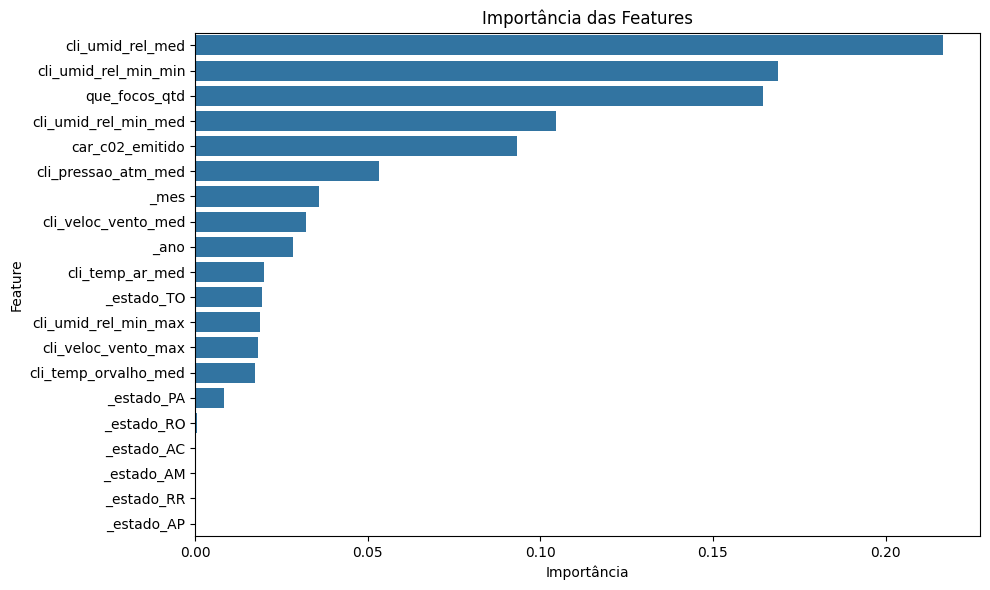

In [38]:
# Criação do DataFrame de importâncias
feature_importances = pd.DataFrame({
    "feature": X_train.columns,
    "importance": BEST_MODEL.feature_importances_
}).sort_values(by="importance", ascending=False)

# Gráfico
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances, x="importance", y="feature")
plt.title("Importância das Features")
plt.xlabel("Importância")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## Resíduos _vs_ Valores Preditos

### Análise

 Para valores de área queimada entre `0.2e6+` e `0.4e6+` hectares o modelo produz menores resíduos, que tendem a aumentar, em módulo, à medida que o valor da predição aumenta. Em particular, note-se que o modelo tende a errar por mais (isto é, produz resíduos negativos) para predições acima de `0.8e6+`.

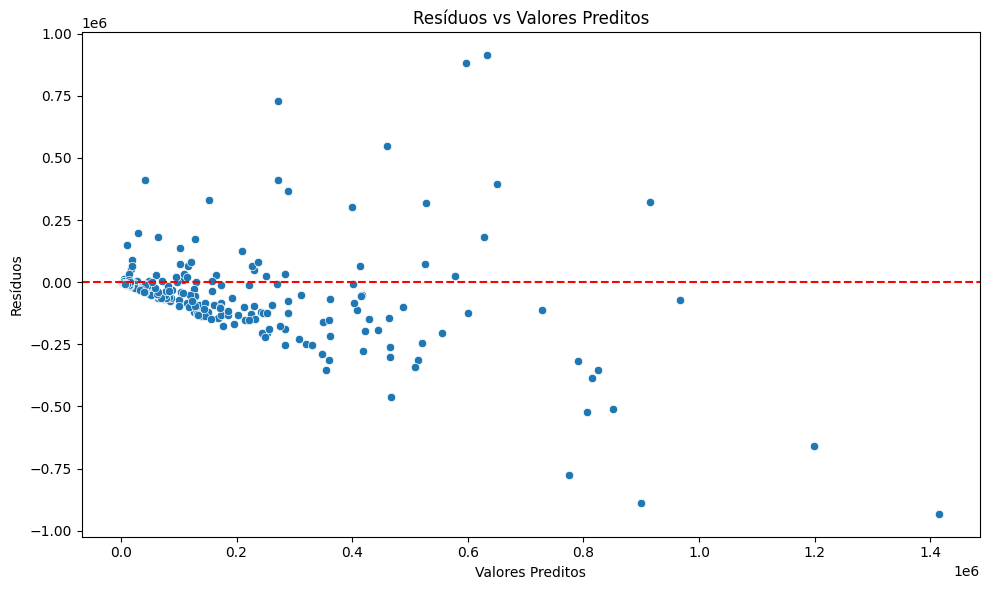

In [39]:
residues = y_test - y_pred

# Gráfico de resíduos
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residues)
plt.axhline(0, color='red', linestyle='--')
plt.title("Resíduos vs Valores Preditos")
plt.xlabel("Valores Preditos")
plt.ylabel("Resíduos")
plt.tight_layout()
plt.show()